<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#IMPORT-PACKAGES" data-toc-modified-id="IMPORT-PACKAGES-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>IMPORT PACKAGES</a></span><ul class="toc-item"><li><span><a href="#Import-customize-functions-for-fitting-data" data-toc-modified-id="Import-customize-functions-for-fitting-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import customize functions for fitting data</a></span></li></ul></li><li><span><a href="#LOAD-DATA" data-toc-modified-id="LOAD-DATA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LOAD DATA</a></span><ul class="toc-item"><li><span><a href="#numbers" data-toc-modified-id="numbers-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>numbers</a></span></li><li><span><a href="#Amplification-curve-processing" data-toc-modified-id="Amplification-curve-processing-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Amplification curve processing</a></span></li><li><span><a href="#Melting-curve-processing" data-toc-modified-id="Melting-curve-processing-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Melting curve processing</a></span></li><li><span><a href="#CREATING-FINAL-DF-+-MASTER" data-toc-modified-id="CREATING-FINAL-DF-+-MASTER-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>CREATING FINAL DF + MASTER</a></span></li><li><span><a href="#Counting-positives" data-toc-modified-id="Counting-positives-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Counting positives</a></span></li></ul></li></ul></div>

# IMPORT PACKAGES

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import time
from datetime import datetime
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('..')

from tqdm.auto import tqdm

## Import customize functions for fitting data

In [3]:
import functions.fitting_func as fitfunc
import functions.peak_finder as peakfunc
import functions.plotting_func as plotfunc
import functions.utilities as utils

utils.colourblind() # load colourblind lib

# LOAD DATA

In [4]:
df_dAC_raw = pd.read_csv("../data/df_AC_raw.csv", low_memory=False)
df_dMC_raw = pd.read_csv("../data/df_MC_raw.csv", low_memory=False)

In [5]:
len(df_dAC_raw.Target.unique())

259

In [6]:
NMETA = 6 # number of meta columns (use for skipping)
PM = "PM5.3"

In [7]:
# reducing the sensitivy of the float - faster
df_dAC_raw.loc[:, df_dAC_raw.dtypes=='float64'] = df_dAC_raw.loc[:, df_dAC_raw.dtypes=='float64'].astype('float16')
df_dMC_raw.loc[:, df_dMC_raw.dtypes=='float64'] = df_dMC_raw.loc[:, df_dMC_raw.dtypes=='float64'].astype('float16')

## numbers

In [8]:
# number of amplification events (total, including gblocks and negatives)
print(df_dMC_raw.shape)

# number of amplification events for gblocks (including negatives)
print(df_dMC_raw.loc[df_dMC_raw.Conc!='unk'].shape)

(342650, 69)
(117810, 69)


In [9]:
# number of clinical isolates (total, including negatives) - excluding gblocks
df_dMC_raw.loc[df_dMC_raw.Conc=='unk'].shape

(224840, 69)

## Amplification curve processing

In [10]:
# background removal from amplification curves
remove_bs = lambda x: fitfunc.remove_background(x, order=0, n_ct_fit=5, n_ct_skip=3)
df_dAC_raw_bs = utils.apply_processing(df_dAC_raw, func=remove_bs, N=NMETA)

In [11]:
ampl_thresh = 0.1 # fluorescence threshold
ct_thresh = 35 # ct threshold

df_dAC_nometa = df_dAC_raw_bs.iloc[:, NMETA:].transpose()
idx_dAC_pos = fitfunc.is_positive_iloc(df_dAC_nometa, ampl_thresh=ampl_thresh, ct_thresh=ct_thresh)
df_dAC_pos = df_dAC_raw_bs.loc[idx_dAC_pos]

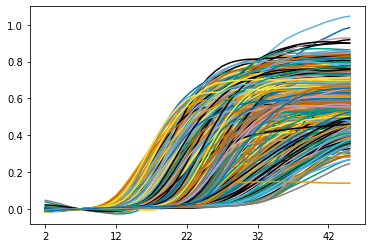

In [12]:
# check curves
df_dAC_pos.iloc[:,NMETA:].sample(1000).T.plot(legend=False)

## Melting curve processing

In [13]:
# MC down-selection of positive samples based on AC thresholds
df_dMC_pos = df_dMC_raw.loc[idx_dAC_pos]

In [14]:
melt_height_thresh = 0.03

# Melting Peaks finder for positives
df_dMC_peak = df_dMC_pos.iloc[:, :NMETA].copy()

df_dMC_nometa = df_dMC_pos.iloc[:, NMETA:].transpose()
df_dMC_nometa.index = df_dMC_nometa.index.map(float)

df_dMC_peak['MeltPeaks'] = peakfunc.find_peaks(df_dMC_nometa, height=melt_height_thresh)

/Users/lucamiglietta/opt/anaconda3/envs/MultiplexAnalysis/lib/python3.6/site-packages/peakutils/peak.py:246: UserWarning: At least 3 points required for Gaussian fitting
  warnings.warn(str(e))


## CREATING FINAL DF + MASTER

In [15]:
# Creating a Master_DF with MC peaks and AC values
df_master = df_dMC_peak.join(df_dAC_pos.iloc[:, NMETA:])

idx_pos_MC_peak = df_master.MeltPeaks.map(len)==1
df_master = df_master[idx_pos_MC_peak]
df_master['MeltPeaks'] = df_master['MeltPeaks'].apply(lambda x: x[0])

# HERE we downselect from the df_ampl the curve with a single value for ["MeltPeaks"]
df_AC_bs_filt = df_dAC_pos[idx_pos_MC_peak] # AC only filtered
df_MC_filt = df_dMC_pos[idx_pos_MC_peak] # MC only filtered
df_MC_peak_filt = df_dMC_peak[idx_pos_MC_peak] # MC peak filtered

In [16]:
df_master

,Channel,PrimerMix,Target,CPE_type,Conc,65,MeltPeaks,2,3,4,...,36,37,38,39,40,41,42,43,44,45
0,panel01,PM5.3,NDM,ndm,10000000,0.003469,90.872576,-0.008057,-0.007324,-0.005859,...,0.782227,0.785156,0.790527,0.795898,0.800781,0.804199,0.809082,0.813965,0.818359,0.821289
1,panel01,PM5.3,NDM,ndm,10000000,0.002085,90.815204,-0.008911,-0.007568,-0.005981,...,0.770508,0.774414,0.779297,0.786133,0.791016,0.792969,0.795898,0.798828,0.802734,0.806641
2,panel01,PM5.3,NDM,ndm,10000000,-0.000755,90.752300,-0.011108,-0.008545,-0.005371,...,0.752441,0.752930,0.753906,0.757324,0.759766,0.760742,0.761230,0.761719,0.764160,0.767578
3,panel01,PM5.3,NDM,ndm,10000000,0.002285,90.711919,-0.009277,-0.007568,-0.005127,...,0.766113,0.767578,0.770020,0.772949,0.775391,0.778320,0.781250,0.785156,0.788574,0.791016
4,panel01,PM5.3,NDM,ndm,10000000,0.001478,90.788061,-0.010986,-0.009155,-0.006348,...,0.753906,0.756836,0.759766,0.764648,0.768555,0.771484,0.776367,0.779297,0.782227,0.783203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342645,panel48,PM5.3,CPO094,ndm,unk,-0.000626,90.924891,-0.004150,-0.004150,-0.003418,...,0.578125,0.578125,0.577637,0.577148,0.577148,0.577637,0.577637,0.577637,0.577637,0.577637
342646,panel48,PM5.3,CPO094,ndm,unk,0.001167,90.943908,-0.003296,-0.002197,-0.001221,...,0.551758,0.552734,0.552734,0.552734,0.552734,0.552734,0.553711,0.553711,0.552734,0.551758
342647,panel48,PM5.3,CPO094,ndm,unk,0.001698,91.448555,-0.002930,-0.003052,-0.002686,...,0.534668,0.535645,0.537598,0.538574,0.539062,0.539551,0.541016,0.542480,0.543945,0.544922
342648,panel48,PM5.3,CPO094,ndm,unk,0.001615,90.903196,-0.003296,-0.002808,-0.002319,...,0.564453,0.564941,0.565918,0.566406,0.567383,0.567383,0.566406,0.565918,0.564941,0.564941


## Counting positives

In [17]:
df_posi_panel = pd.DataFrame(columns=["positives"])

# get all sample with unk Concentration
df_unk = df_MC_filt.loc[df_MC_filt.Conc=="unk"]

for channel, df_channel in df_unk.groupby("Target"):
    df_posi_panel.loc[channel] = df_channel.shape[0]

df_posi_panel.index.name = "sampleID"
df_posi_panel.reset_index(inplace=True)

# WE CLASSIFY PANEL BASED ON HAVING MORE THAN 5% OCCUPANCY (5% of 770 wells = 39)
df_neg = df_posi_panel.loc[df_posi_panel.positives<39] 

In [18]:
df_master = df_master.loc[~df_master.Target.isin(df_neg.sampleID)]
df_AC_bs_filt = df_AC_bs_filt.loc[~df_AC_bs_filt.Target.isin(df_neg.sampleID)]
df_MC_filt = df_MC_filt.loc[~df_MC_filt.Target.isin(df_neg.sampleID)]
df_MC_peak_filt = df_MC_peak_filt.loc[~df_MC_peak_filt.Target.isin(df_neg.sampleID)]

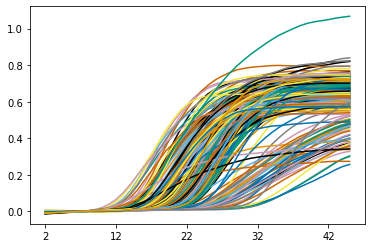

In [20]:
df_master.iloc[:,NMETA+1:].sample(200).T.plot(legend=False)

In [21]:
# # SAVING EVERYTHING
# df_type = 'pos'

# df_master.to_csv(f"dataframes_saved/02_df_master_{df_type}.csv")
# df_AC_bs_filt.to_csv(f"dataframes_saved/02_df_AC_bs_{df_type}.csv")
# df_MC_filt.to_csv(f"dataframes_saved/02_df_MC_{df_type}.csv")